In [1]:
import gurobipy as grb
import numpy as np
import math
import sys

In [2]:
def distance(x, y):
    return np.sqrt(np.sum((x-y)**2))

### Problem parameters

In [3]:
p = 5
M = 100 # clients
N = 100 # facilities

# x_j      facility j is opened
# y_{i_j} customer i supplied by facility j
# d_{i_j} supply cost for customer i with facility j 

In [4]:
facilities = np.random.uniform(low=0, high=1, size=[N, 2])
clients = np.random.uniform(low=0, high=1, size=[M, 2])

## Using gurobi

In [5]:
import timeit
start_time = timeit.default_timer()

In [6]:
m = grb.Model()
m.setParam('OutputFlag', False)

Academic license - for non-commercial use only


### Add variables

In [7]:
x = {}
y = {}
d = {}

distances = [[distance(clients[i], facilities[j]) for j in range(N)] for i in range(M)]

for j in range(N):
    x[j] = m.addVar(lb=0, ub=1, vtype=grb.GRB.BINARY, name="x_%d" % j)

for i in range(M):
    for j in range(N):
        y[(i, j)] = m.addVar(lb=0, ub=1, vtype=grb.GRB.BINARY, name="y_%d_%d" % (i, j))
        
        d[(i, j)] = distances[i][j]

### Add constrains

In [8]:
%%capture
for i in range(M):
    for j in range(N):
        m.addConstr(y[(i, j)] <= x[j])

for i in range(M):
    m.addConstr(grb.quicksum(y[(i, j)] for j in range(N)) == 1)

m.addConstr(grb.quicksum(x[j] for j in range(N)) == p)

### Objective function

In [9]:
m.setObjective(grb.quicksum(grb.quicksum(
    d[(i, j)]*y[(i, j)] for i in range(M)) for j in range(N)), grb.GRB.MINIMIZE)

### Solve

In [10]:
m.optimize()
gurobi_obj = m.objVal

In [152]:
gurobi_obj

16.364042239381824

In [11]:
x_gurobi = [0 for j in range(N)]
y_gurobi = [[0 for j in range(N)] for i in range(M)]
for j in range(N):
    x_gurobi[j] = int(m.getVarByName("x_%d" % (j)).X)
    
for i in range(M):
    for j in range(N):
        y_gurobi[i][j] = int(m.getVarByName("y_%d_%d" % (i,j)).X)

### Time elapsed

In [12]:
elapsed_by_gurobi = timeit.default_timer() - start_time
print(elapsed_by_gurobi)

15.049159892000262


## Simulated annealing

In [994]:
import matplotlib.pyplot as plt

In [87]:
f_distances = [[distance(facilities[i], facilities[j]) for j in range(N)] for i in range(M)]

In [106]:
def generate_x():
    x = [0 for j in range(N)]
    for i in range(p):
        x[i] = 1
    _= np.random.shuffle(x)
    return x

In [155]:
def list_opened_facilites(x):
    output = []
    for j in range(N):
        if x[j] == 1:
            output.append(j)
    return output

In [154]:
def available_disnaces(x,d):
    output = [[np.inf for j in range(N)] for i in range(M)]
    for i in range(M):
        for ind in list_opened_facilites(x):
            output[i][ind] = d[i][ind]
    return(output)

In [75]:
def define_y(d):
    y = [[0 for j in range(N)] for i in range(M)]
    for i in range(M):
        y[i][np.argmin(d[i])] = 1
    return y

In [882]:
def goal_func(x):
    d = available_disnaces(x,distances)
    y = define_y(d)
    return np.sum([[distances[i][j]*y[i][j] for i in range(M)] for j in range(N)])

In [897]:
def mutate(x):
#     x = x_in[:]
    mutate_batch = round(0.2*p)
    opened_f = list_opened_facilites(x)
    
    facilities_to_mutate = []
    for k in range(mutate_batch):
        facilities_to_mutate.append(opened_f.pop(np.random.randint(0,len(opened_f))))
    
    candidates_list = list(range(M))
    for j in facilities_to_mutate:
#         candidates_list = np.asarray([[ndx,dist] for ndx,dist in enumerate(f_distances[j])])
#         candidates_list = candidates_list[candidates_list[:,1].argsort()]
#         candidates_list = [[int(a[0]),a[1]] for a in candidates_list]
        mutated = False
#         candidate_mutate_to = 0
        while not mutated:
            candidate_mutate_to = np.random.choice(candidates_list)
#             if not(candidates_list[candidate_mutate_to][0] in facilities_to_mutate):
            if not(candidate_mutate_to in facilities_to_mutate):
                mutated = True
        x[j] = 0
        x[candidate_mutate_to] = 1
        del candidates_list[candidate_mutate_to]
    return x

In [989]:
def simulated_annealing(T,Tmin,r):
    cur_x = generate_x()
    best_x = cur_x
    cur_gf = goal_func(cur_x)
    best_gf = cur_gf
    
    data = [best_gf]
    while T > Tmin:
        x = mutate(cur_x)
        gf = goal_func(x) 
        if (gf-cur_gf)<0:
            cur_gf = gf
            cur_x = x
            data.append(cur_gf)
        elif (np.random.rand() < np.exp(-(gf-cur_gf)/T)):
            cur_gf = gf
            cur_x = x
            data.append(cur_gf)
        if (best_gf > gf):
            best_x = x
            best_gf = gf
        T *= r
    return best_gf, data

Optimal solution:  16.364042239381824 
Simulated annealing:  18.832105364724484

Elapsed time by gurobi: 15.049159892000262 
Elapsed time by simulated annealing: 12.48700370000006


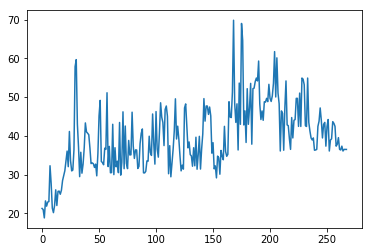

In [1002]:
start_time = timeit.default_timer()

gf, data = simulated_annealing(100,1,0.99)
print('Optimal solution: ', gurobi_obj, '\nSimulated annealing: ', gf)

print('\nElapsed time by gurobi:', elapsed_by_gurobi, '\nElapsed time by simulated annealing:',
      timeit.default_timer() - start_time)

_=plt.plot(data)
_=plt.show()